In [35]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from sklearn.metrics import f1_score
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

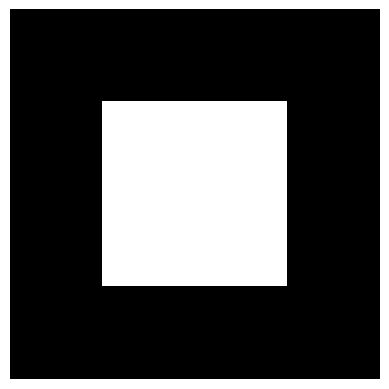

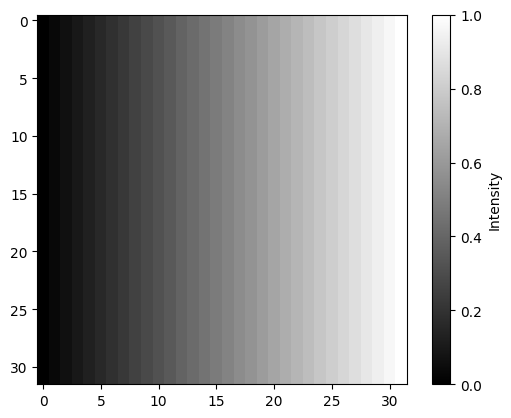

In [46]:
# create a visual stimulus 
def create_stimulus(size = 32):
    stim = np.zeros((size, size))
    stim[size//4:3*size//4, size//4:3*size//4] = 1.0  # Bright square
    return stim

# create a contrast gradient
def create_contrast_gradient(size = 32, level = 1.0):
    return np.tile(np.linspace(0, level, size), (size, 1))

# Difference of Gaussians centre-surround filter
def centre_surround_filter(size = 21, centre_sigma = 1, surround_sigma = 3, inhibition_strength = 1.0):
    x = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, x)
    centre = np.exp(-(X**2 + Y**2) / (2 * centre_sigma**2))
    surround = np.exp(-(X**2 + Y**2) / (2 * surround_sigma**2))
    centre /= centre.sum()
    surround /= surround.sum()
    return centre - inhibition_strength * surround

# retina simulation
def run_retina_sim(stimulus, kernel, tau_ms = 10, threshold = 1.0):
    convolved = convolve(stimulus, kernel, mode='reflect').flatten()
    start_scope()

    N = stimulus.size
    tau = tau_ms * ms

    eqs = '''
    dv/dt = (-v + input_current) / tau : 1
    input_current : 1
    '''

    neurons = NeuronGroup(N, eqs, threshold = 'v > {}'.format(threshold), reset = 'v = 0', method = 'euler')
    neurons.input_current = convolved
    mon = StateMonitor(neurons, 'v', record = True)

    run(100 * ms)
    output = mon.v[:, -1].reshape(stimulus.shape)
    return convolved.reshape(stimulus.shape), output


stimulus = create_stimulus()

# Plot the stimulus
plt.figure()
plt.imshow(stimulus, cmap='gray')
plt.axis('off')
plt.show()


gradient = create_contrast_gradient()
# plot the contrast gradient 
plt.figure()
plt.imshow(gradient, cmap = 'gray')
plt.colorbar(label = 'Intensity')
plt.show()

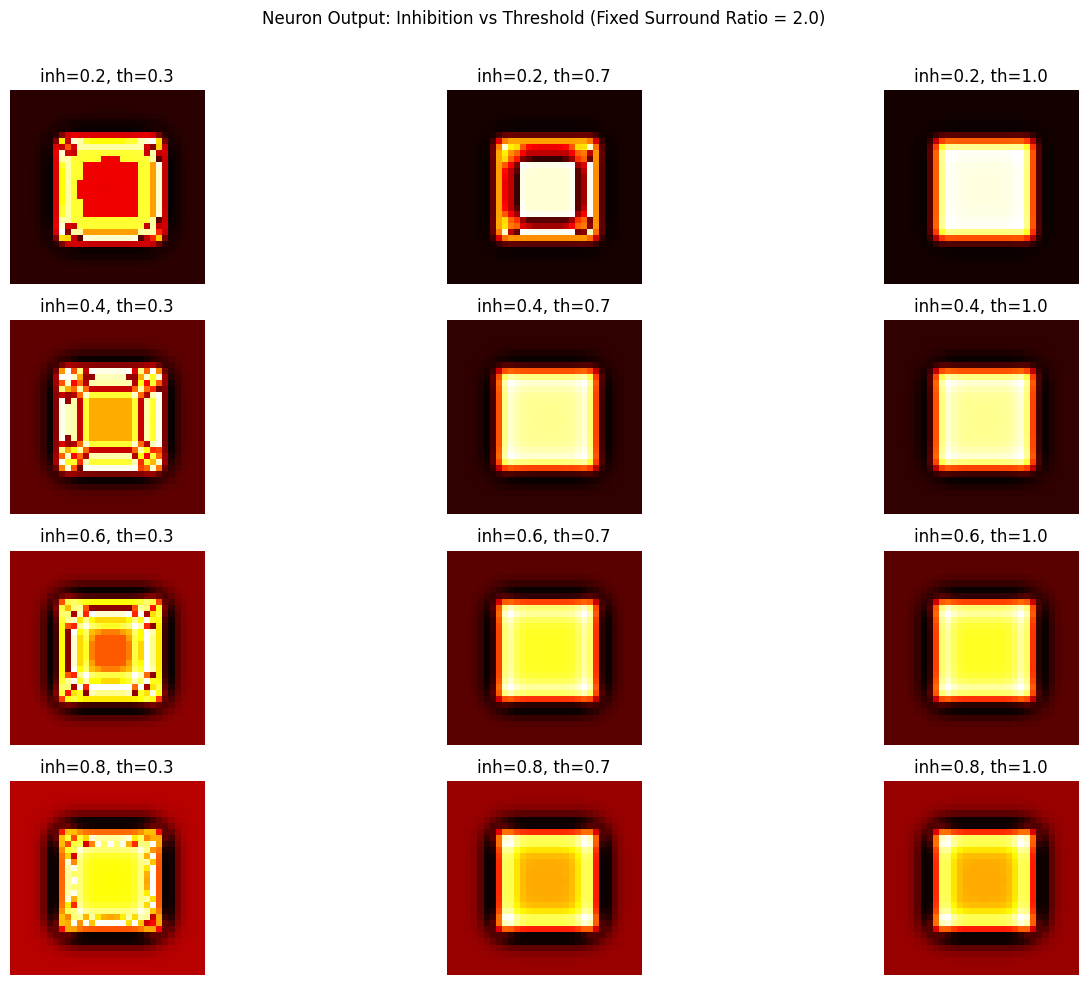

   inhibition  surround_ratio  threshold  f1_score  mean_contrast_response
0         0.2             1.5        0.3  0.000000                0.164649
1         0.2             1.5        0.7  0.884532                0.365069
2         0.2             1.5        1.0  0.935551                0.388235
3         0.2             2.0        0.3  0.000000                0.164495
4         0.2             2.0        0.7  0.573816                0.345744


In [47]:
def run_trials():
    inhibition_values = [0.2, 0.4, 0.6, 0.8]
    surround_ratios = [1.5, 2.0, 3.0]
    thresholds = [0.3, 0.7, 1.0]

    trial_results = []
    edge_stimulus = create_stimulus()
    gradient_stimulus = create_contrast_gradient()

    for inhibition in inhibition_values:
        for surround_ratio in surround_ratios:
            for threshold in thresholds:
                kernel = centre_surround_filter(centre_sigma = 1, surround_sigma = 1*surround_ratio, inhibition_strength = inhibition)

                # F1 Score on edge detection
                _, output_edge = run_retina_sim(edge_stimulus, kernel, tau_ms = 10, threshold = threshold)
                ground_truth = (edge_stimulus > 0).astype(int).flatten()
                prediction = (output_edge > 0.5).astype(int).flatten()
                f1 = f1_score(ground_truth, prediction)

                # Mean output on contrast gradient
                _, output_gradient = run_retina_sim(gradient_stimulus, kernel, tau_ms = 10, threshold = threshold)
                mean_response = output_gradient.mean()

                trial_results.append({
                    'inhibition': inhibition,
                    'surround_ratio': surround_ratio,
                    'threshold': threshold,
                    'f1_score': f1,
                    'mean_contrast_response': mean_response
                })

    fig, axs = plt.subplots(len(inhibition_values), len(thresholds), figsize=(15, 10))
    fig.suptitle("Neuron Output: Inhibition vs Threshold (Fixed Surround Ratio = 2.0)")

    for i, inhibition in enumerate(inhibition_values):
        for j, threshold in enumerate(thresholds):
            kernel = centre_surround_filter(centre_sigma=1, surround_sigma=2.0, inhibition_strength=inhibition)
            _, neuron_output = run_retina_sim(stimulus, kernel, tau_ms=10, threshold=threshold)
            axs[i, j].imshow(neuron_output, cmap='hot')
            axs[i, j].axis('off')
            axs[i, j].set_title(f"inh={inhibition}, th={threshold}")

            ground_truth = (stimulus > 0).astype(int).flatten()
            prediction = (neuron_output > 0.5).astype(int).flatten()
            score = f1_score(ground_truth, prediction)
            f1_scores.append((inhibition, 2.0, threshold, score))

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    return pd.DataFrame(trial_results)

# Example run
df_results = run_trials()
df_results.to_csv("results.csv", index = False)
print(df_results.head())



In [29]:
# contrast response curve
def run_contrast_response_curve(kernel, threshold, contrast_levels = np.linspace(0.1, 1.0, 10)):
    means = []
    for level in contrast_levels:
        stim = create_contrast_gradient(level = level)
        _, output = run_retina_sim(stim, kernel, threshold = threshold)
        means.append(output.mean())
    return contrast_levels, means


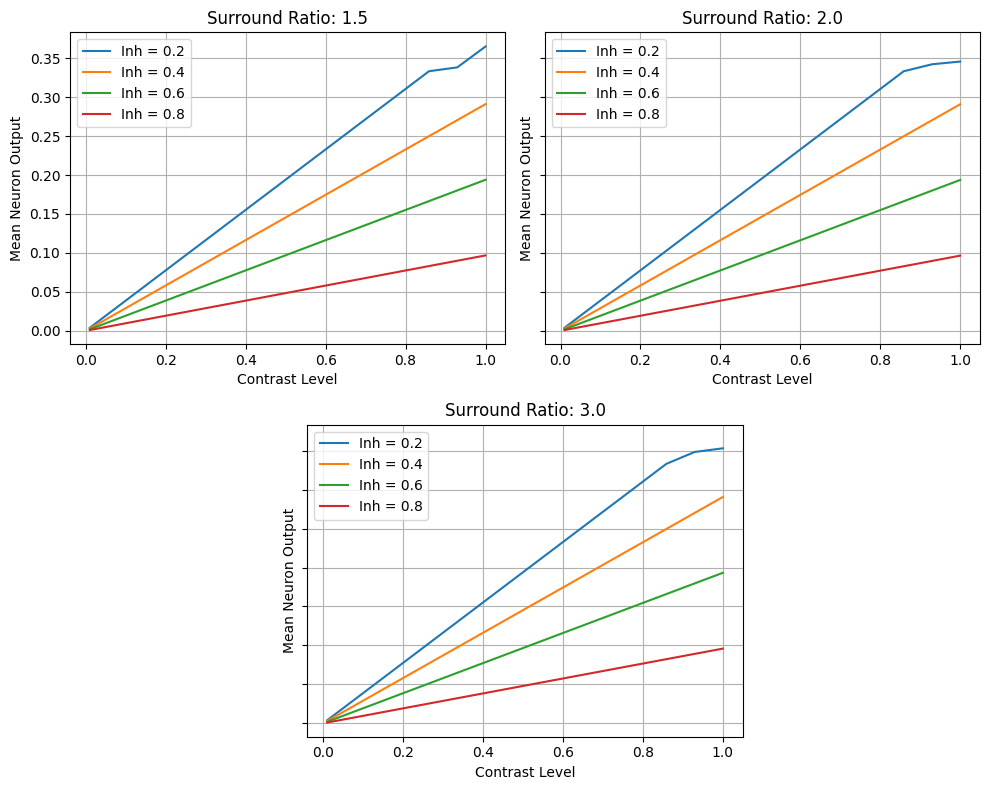

In [ ]:
import matplotlib.pyplot as plt

# Parameters to sweep
contrast_levels = np.linspace(0.01, 1.0, 15)
threshold_fixed = 0.7  # Fix threshold across comparisons
inhibition_values = [0.2, 0.4, 0.6, 0.8]
surround_ratios = [1.5, 2.0, 3.0]

mosaic = """AABB
            .CC."""

surround_labels = ["A", "B", "C"]  # maps to keys in mosaic

# Plotting setup
fig, ax_dict = plt.subplot_mosaic(mosaic, figsize = (10, 8), sharey = True)

for label, surround_ratio in zip(surround_labels, surround_ratios):
    ax = ax_dict[label]
    for inhibition in inhibition_values:
        kernel = centre_surround_filter(
            centre_sigma = 1,
            surround_sigma = 1 * surround_ratio,
            inhibition_strength = inhibition
        )
        contrast_levels, mean_outputs = run_contrast_response_curve(kernel, threshold_fixed, contrast_levels)
        ax.plot(contrast_levels, mean_outputs, label = f"Inh = {inhibition}")

    ax.set_title(f"Surround Ratio: {surround_ratio}")
    ax.set_xlabel("Contrast Level")
    if ax == 'AA':
        ax.set_ylabel("Mean Neuron Output")
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


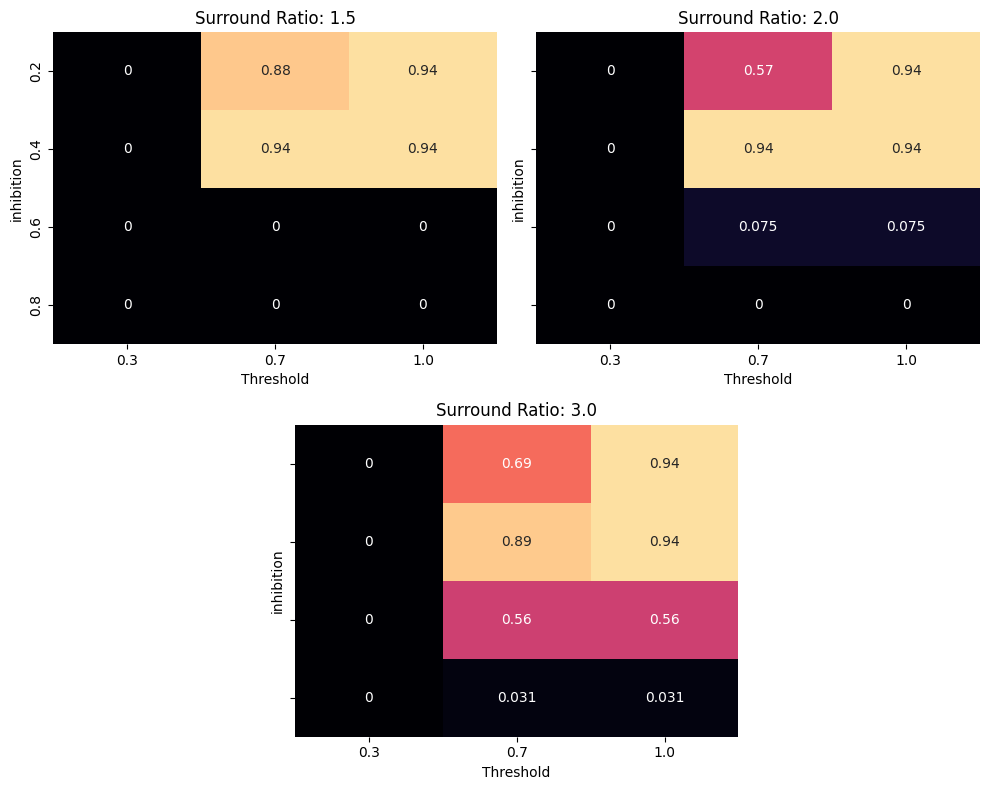

In [43]:
# edge detection analysis 
def plot_f1_heatmaps(df):
    surround_values = sorted(df['surround_ratio'].unique())
    labels = ['A', 'B', 'C'][:len(surround_values)]

    mosaic = """AABB
            .CC."""
    
    fig, ax_dict = plt.subplot_mosaic(mosaic, figsize = (10, 8), sharey = True)

    for label, surround in zip(labels, surround_values):
        ax = ax_dict[label]
        subset = df[df['surround_ratio'] == surround]
        pivot = subset.pivot(index = 'inhibition', columns = 'threshold', values = 'f1_score')

        sns.heatmap(pivot, annot = True, cmap = 'magma', cbar = False, ax = ax, vmin = 0, vmax = 1)
        ax.set_title(f"Surround Ratio: {surround}")
        ax.set_xlabel("Threshold")

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

plot_f1_heatmaps(df_results)